In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [4]:
df = pd.read_csv('/content/AB_NYC_2019.csv')


In [5]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [6]:
# Calculate the total number of rows with at least one missing value
total_rows_with_missing_values = df.isna().any(axis=1).sum()

# Print the total number of rows with missing values
print(f'Total number of rows with at least one missing value: {total_rows_with_missing_values}')

df.isna().sum()


Total number of rows with at least one missing value: 10074


id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

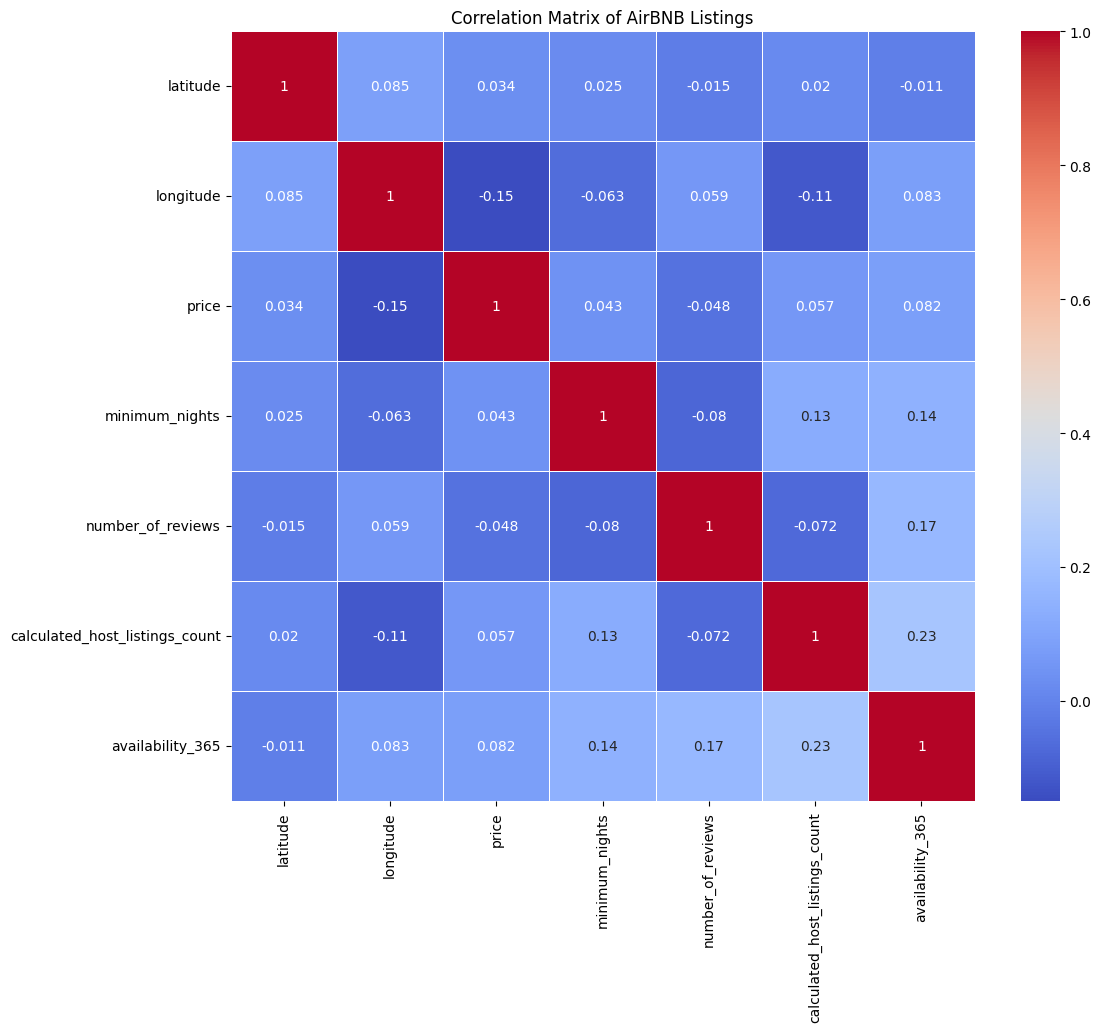

In [7]:
# Drop the 'id', 'host_id', and 'reviews_per_month' columns
df = df.drop(columns=['id', 'host_id', 'reviews_per_month', 'last_review'])


# Select only numeric columns for the correlation matrix
numeric_cols = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of AirBNB Listings')
plt.show()


- No Correlation between any of the variables

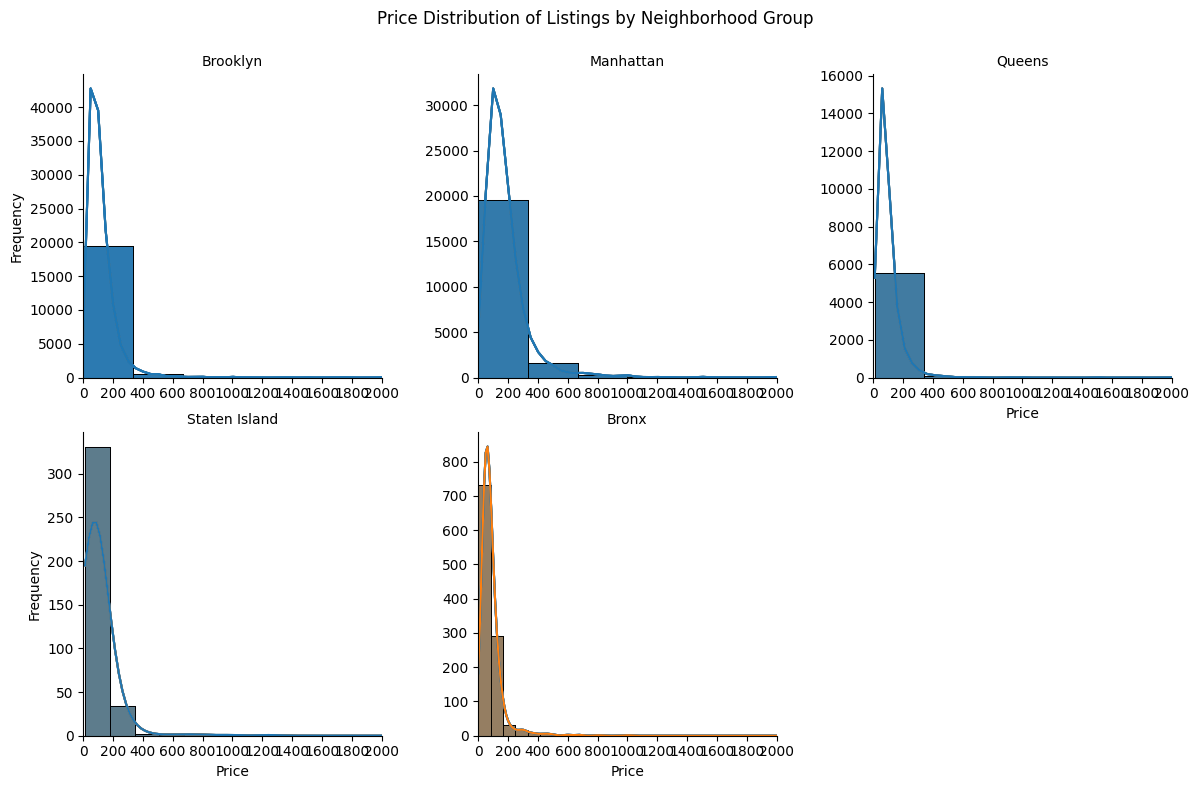

In [8]:
neighborhood_colors = {
    'Brooklyn': 'dodgerblue',
    'Manhattan': 'darkorange',
    'Queens': 'forestgreen',
    'Staten Island': 'mediumvioletred',
    'Bronx': 'gold'
}

# Create the FacetGrid
g = sns.FacetGrid(df, col="neighbourhood_group", col_wrap=3, height=4, sharex=False, sharey=False)

# Map the histogram plot with custom colors
for neighborhood, color in neighborhood_colors.items():
    g.map_dataframe(sns.histplot, "price", bins=30, kde=True, color=color,
                    hue=df['neighbourhood_group'] == neighborhood)

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Price", "Frequency")

# Adjust the x-axis limits and ticks for better readability
for ax in g.axes.flat:
    ax.set_xlim(0, 2000)  # Set the x-axis limit to a more reasonable range
    ax.set_xticks(range(0, 2001, 200))  # Set the ticks at intervals of 200

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Price Distribution of Listings by Neighborhood Group')

plt.show()


Observations

Manhattan and Brooklyn: Both have the highest frequency of listings and the widest range of prices, including significant high-priced outliers.
Queens: Has a moderate frequency of listings with generally lower prices compared to Manhattan and Brooklyn.
Staten Island and Bronx: Both have lower frequencies of listings and more affordable prices, with limited outliers in the higher price ranges.

In [9]:
# Filter listings for Manhattan, Brooklyn, and Queens
filtered_df = df[df['neighbourhood_group'].isin(['Manhattan', 'Brooklyn', 'Queens'])]

# Select relevant columns for summary statistics
columns_of_interest = ['neighbourhood_group', 'availability_365', 'number_of_reviews', 'minimum_nights', 'price', 'longitude', 'latitude']

# Compute mean and standard deviation for each neighborhood group
summary_stats = filtered_df[columns_of_interest].groupby('neighbourhood_group').agg(['mean', 'std']).reset_index()

# Flatten the MultiIndex columns
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]

# Rename columns for better readability
summary_stats.rename(columns={
    'neighbourhood_group_': 'Neighborhood Group',
    'availability_365_mean': 'Availability Mean',
    'availability_365_std': 'Availability Std',
    'number_of_reviews_mean': 'Reviews Mean',
    'number_of_reviews_std': 'Reviews Std',
    'minimum_nights_mean': 'Min Nights Mean',
    'minimum_nights_std': 'Min Nights Std',
    'price_mean': 'Price Mean',
    'price_std': 'Price Std',
    'longitude_mean': 'Longitude Mean',
    'longitude_std': 'Longitude Std',
    'latitude_mean': 'Latitude Mean',
    'latitude_std': 'Latitude Std'
}, inplace=True)

# Style the DataFrame with a single color scheme
styled_stats = summary_stats.style.format({
    "Availability Mean": "{:.2f}", "Availability Std": "{:.2f}",
    "Reviews Mean": "{:.2f}", "Reviews Std": "{:.2f}",
    "Min Nights Mean": "{:.2f}", "Min Nights Std": "{:.2f}",
    "Price Mean": "{:.2f}", "Price Std": "{:.2f}",
    "Longitude Mean": "{:.5f}", "Longitude Std": "{:.5f}",
    "Latitude Mean": "{:.5f}", "Latitude Std": "{:.5f}"
}).background_gradient(cmap='Blues', subset=[
    "Availability Mean", "Availability Std", "Reviews Mean", "Reviews Std",
    "Min Nights Mean", "Min Nights Std", "Price Mean", "Price Std",
    "Longitude Mean", "Longitude Std", "Latitude Mean", "Latitude Std"
])

styled_stats

,Neighborhood Group,Availability Mean,Availability Std,Reviews Mean,Reviews Std,Min Nights Mean,Min Nights Std,Price Mean,Price Std,Longitude Mean,Longitude Std,Latitude Mean,Latitude Std
0,Brooklyn,100.23,126.28,24.20,44.34,6.06,17.63,124.38,186.87,-73.95119,0.02548,40.68504,0.02740
1,Manhattan,111.98,132.68,20.99,42.57,8.58,24.05,196.88,291.38,-73.97461,0.02214,40.76506,0.03846
2,Queens,144.45,135.54,27.70,51.96,5.18,15.03,99.52,167.10,-73.87277,0.05699,40.73153,0.04037


Location:

Manhattan's higher prices are likely driven by its central location and proximity to key attractions, business centers, and luxury amenities. The geographical coordinates suggest that high-end listings are located in desirable areas, which command premium prices.

Minimum Nights Requirement:

Higher minimum night requirements in Manhattan suggest that longer-term stays are more common, which could contribute to higher overall prices as hosts cater to guests looking for extended accommodations.

Listing Quality and Amenities:

The high standard deviation in prices for Manhattan indicates a wide range of listing qualities, from high-end apartments to luxury penthouses. The amenities and overall quality of listings likely play a significant role in driving prices up in this area.

Review Dynamics:

The number of reviews does not directly correlate with higher prices, particularly in Manhattan, where listings command high prices regardless of review count. This indicates that reputation and user feedback, while important, are secondary to location and quality in driving high-end prices.
In summary, the primary drivers of high-end Airbnb prices in Manhattan, Brooklyn, and Queens are likely related to location, quality of listings, and minimum stay requirements. Manhattan, in particular, benefits from its central location and the range of luxury offerings, which justify its higher prices.

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Filter listings for Manhattan, Brooklyn, and Queens
filtered_df = df[df['neighbourhood_group'].isin(['Manhattan', 'Brooklyn'])]

filtered_df = filtered_df.sort_values(by='price', ascending=False)

# Select the top quartile based on price
top_quartile_threshold = filtered_df['price'].quantile(0.75)
top_quartile_df = filtered_df[filtered_df['price'] >= top_quartile_threshold]

top_quartile_df[columns_of_interest].groupby('neighbourhood_group').agg(['mean', 'std']).reset_index()

top_quartile_df.isna().sum()

top_quartile_df = top_quartile_df.dropna()

# Select relevant columns
columns_of_interest = ['availability_365', 'number_of_reviews', 'minimum_nights', 'price', 'longitude', 'latitude', 'room_type', 'neighbourhood_group']

# Filter the relevant columns
top_quartile_df = top_quartile_df[columns_of_interest]


# Define the preprocessing steps for numerical and categorical data
numerical_features = ['availability_365', 'number_of_reviews', 'minimum_nights', 'price', 'longitude', 'latitude']
categorical_features = ['room_type', 'neighbourhood_group']

In [11]:
numerical_transformer = StandardScaler()

# One-hot encode categorical features
categorical_transformer = OneHotEncoder(drop='first')

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply the transformations
X_preprocessed = preprocessor.fit_transform(top_quartile_df)

X_preprocessed

array([[-0.39312728, -0.4866207 ,  1.10879442, ...,  0.        ,
         0.        ,  1.        ],
       [-0.99489733, -0.34825709, -0.16542625, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99489733, -0.45894798, -0.16542625, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.99489733, -0.45894798, -0.36930156, ...,  1.        ,
         0.        ,  1.        ],
       [-0.49463066,  0.23287005, -0.2673639 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.99489733, -0.29291165, -0.31833273, ...,  0.        ,
         0.        ,  1.        ]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

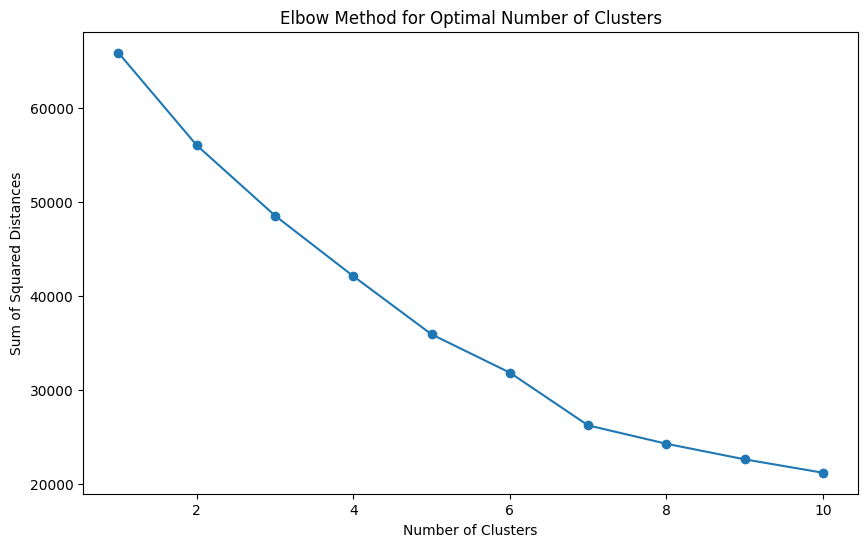

In [12]:
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed)
    sse.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

In the elbow plot:
The rate of decrease in the sum of squared distances is steep initially and starts to slow down after a certain point.
The elbow appears to be around 4 clusters, as the plot starts to bend at this point.
Conclusion
Based on the elbow method, the optimal number of clusters appears to be 4.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   cluster  availability_365  number_of_reviews  minimum_nights     price  \
0        0          0.473071           3.040162       -0.211558 -0.157995   
1        1         -0.731996          -0.234407       -0.210802 -0.083292   
2        2          1.169521          -0.260402        0.520926  0.227285   
3        3         -0.256206          -0.147004       -0.191011 -0.079724   

   longitude  latitude  room_type_Private room  room_type_Shared room  \
0   0.034882 -0.070773                0.041076               0.002833   
1  -0.317529  0.423221                0.087322               0.007004   
2  -0.281126  0.374382                0.109417               0.001355   
3   0.851785 -1.128193                0.075924               0.003934   

   neighbourhood_group_Manhattan  
0                       0.674221  
1                       0.997432  
2                       0.956301  
3                       0.000000  


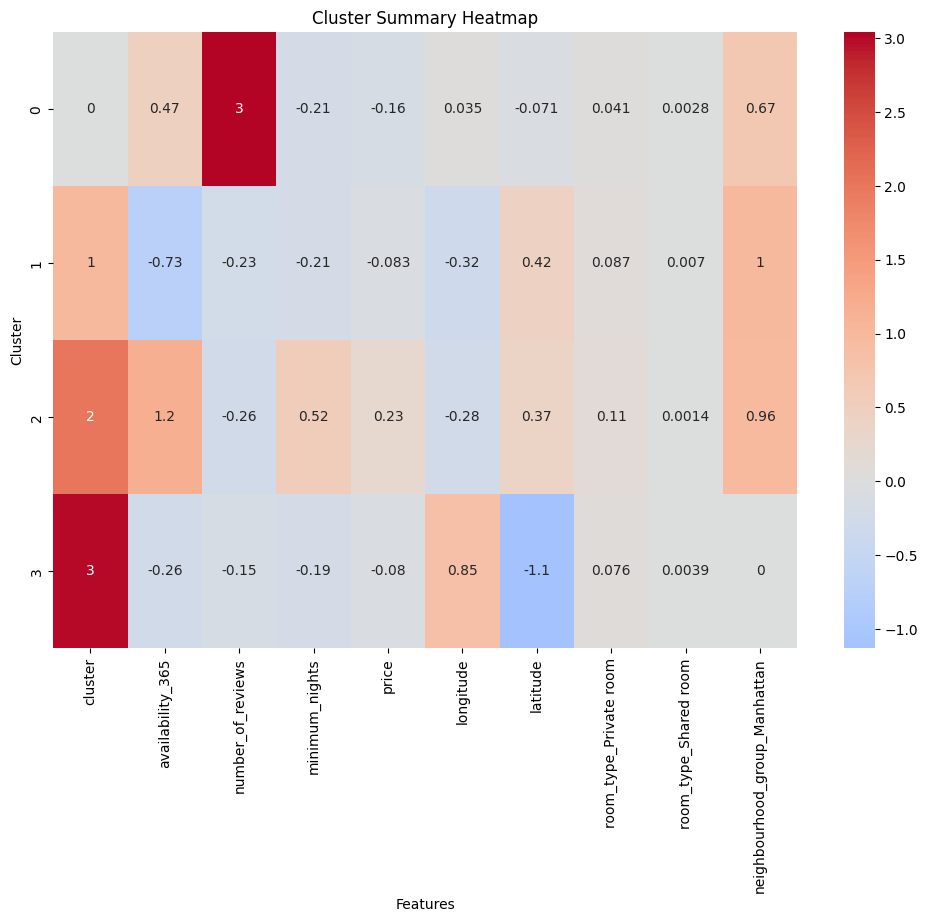

In [20]:
from sklearn.cluster import KMeans

# Perform K-means clustering with the optimal number of clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_preprocessed)
y_kmeans = kmeans.fit_predict(X_preprocessed)

# Get the cluster labels
clusters = kmeans.labels_

# Get feature names after transformation
num_features = numerical_features
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(num_features) + list(cat_features)

# Create a DataFrame from the preprocessed data
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# Add the cluster labels to the original DataFrame
X_preprocessed_df['cluster'] = clusters

# Group by the cluster labels and calculate the mean for each cluster
cluster_summary = X_preprocessed_df.groupby('cluster').mean().reset_index()

# Display the summary table
print(cluster_summary)


# Plot the heatmap with features on the y-axis and clusters on the x-axis
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary, annot=True, cmap='coolwarm', center=0)
plt.title('Cluster Summary Heatmap')
plt.xlabel('Features')  # X-axis label for clusters
plt.ylabel('Cluster')  # Y-axis label for features
plt.show()




The analysis of the clusters reveals distinct profiles for travelers willing to spend more on Airbnb listings. High spenders, represented by Cluster 2, prefer entire homes or apartments in Manhattan, seek higher availability, and opt for longer stays. These luxury travelers prioritize comfort and extended accommodations, willing to pay premium prices for their stays.

In contrast, customers who not encesarily are the highest spenders but do spend a bit more than the avarageare spread across Clusters 0, 1, and 3. Cluster 0 consists of travelers who value highly-reviewed and popular listings in Manhattan. They prefer shorter stays and predominantly choose private rooms, indicating a strong emphasis on review quality and value for money. Cluster 1 includes travelers looking for cost-effective options with short stays in high-demand listings, also located in Manhattan. These travelers prioritize cost and booking convenience, often opting for private rooms. Finally, Cluster 3 represents budget-conscious travelers in Brooklyn who seek affordable entire homes or apartments. They prefer shorter stays and moderately popular listings, balancing cost and comfort in their accommodation choices.



In [ ]:
print(cluster_summary)

In [14]:
# Create a DataFrame from the preprocessed data
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# Add the cluster labels to the original DataFrame
X_preprocessed_df['cluster'] = clusters

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x78ab8c62c820> (for post_execute):


KeyboardInterrupt: 

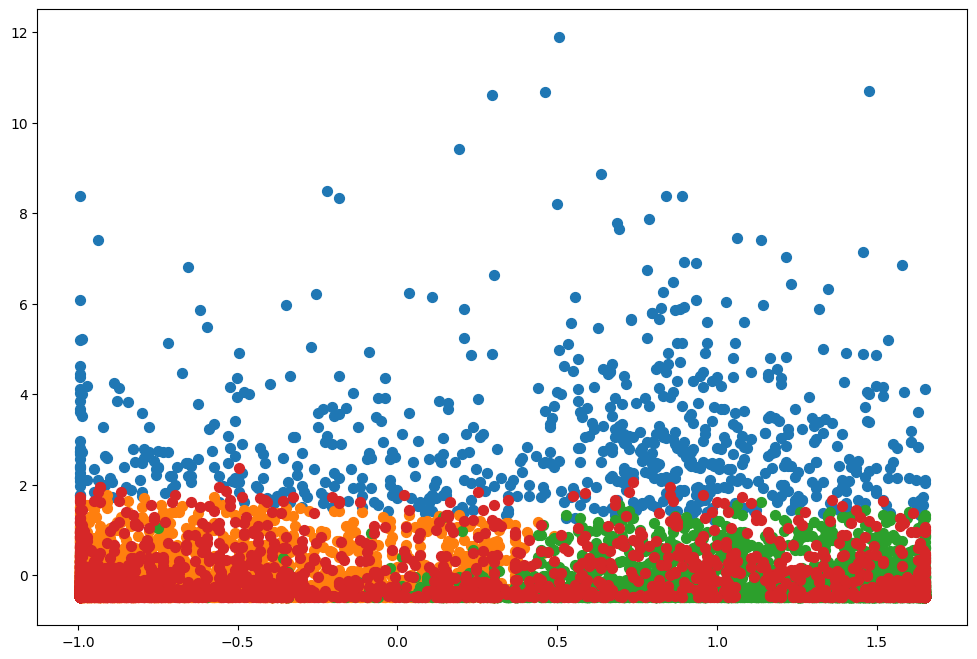

In [25]:
# Plot the clustermap with features on the y-axis and clusters on the x-axis

plt.figure(figsize=(12, 8))
for i in range (len(clusters)):
    plt.scatter(X_preprocessed[y_kmeans == i,0],
    X_preprocessed[y_kmeans == i, 1],
    s=50,
    label=f'Cluster{i+1}')

# Plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')

plt.title('K-means Clustering')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.legend()
plt.grid(True)
plt.show()




In [15]:
X_preprocessed_df

,availability_365,number_of_reviews,minimum_nights,price,longitude,latitude,room_type_Private room,room_type_Shared room,neighbourhood_group_Manhattan,cluster
0,-0.393127,-0.486621,1.108794,21.870983,-0.435307,0.979983,0.0,0.0,1.0,2
1,-0.994897,-0.348257,-0.165426,21.870983,0.884167,-0.057175,0.0,0.0,0.0,2
2,-0.994897,-0.458948,-0.165426,21.868716,1.714363,1.518108,0.0,0.0,1.0,2
3,1.651441,-0.486621,1.108794,21.868716,-0.390663,-0.393012,0.0,0.0,1.0,2
4,-0.393127,-0.320584,4.625643,21.868716,-0.364057,-0.556994,1.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...
10478,-0.559883,-0.237566,-0.318333,-0.367808,0.756098,-0.088135,0.0,0.0,0.0,3
10479,-0.994897,-0.375930,-0.267364,-0.367808,-0.999894,0.706853,0.0,0.0,1.0,1
10480,-0.994897,-0.458948,-0.369302,-0.367808,-0.276122,0.000547,1.0,0.0,1.0,1
10481,-0.494631,0.232870,-0.267364,-0.367808,1.468596,-0.187836,0.0,0.0,0.0,3


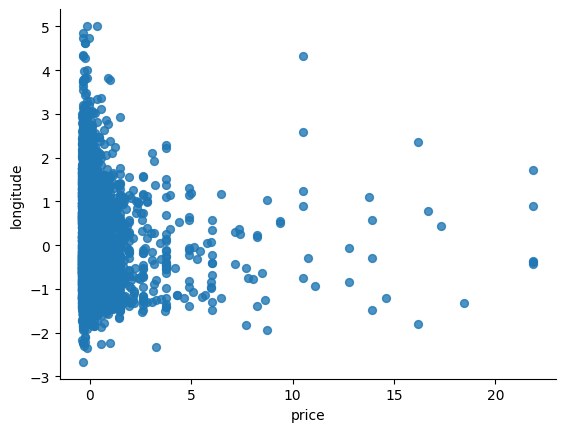

In [16]:
# @title price vs longitude

from matplotlib import pyplot as plt
X_preprocessed_df.plot(kind='scatter', x='price', y='longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [1]:
import folium
import pandas as pd
from IPython.display import display
import geopandas # Import the geopandas library

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
filtered_df

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
29238,1-BR Lincoln Center,Jelena,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,1,83
17692,Luxury 1 bedroom apt. -stunning Manhattan views,Erin,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,1,0
6530,Spanish Harlem Apt,Olson,Manhattan,East Harlem,40.79264,-73.93898,Entire home/apt,9999,5,1,1,0
40433,2br - The Heart of NYC: Manhattans Lower East ...,Matt,Manhattan,Lower East Side,40.71980,-73.98566,Entire home/apt,9999,30,0,1,365
12342,"Quiet, Clean, Lit @ LES & Chinatown",Amy,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,1,83
...,...,...,...,...,...,...,...,...,...,...,...,...
25634,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,5,0
26259,the best you can find,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,1,0
26841,Coliving in Brooklyn! Modern design / Shared room,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,6,333
25796,Cozy yet spacious private brownstone bedroom,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,6,222


In [ ]:
manhattan = nyc_boroughs[nyc_boroughs['BORONAME'] == 'Manhattan']

def plot_Manhattan_Map(dfmanhat, manhattan):
    # Creating a map centered around Manhattan
    manhat_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

    data = dfmanhat[["neighbourhood", "latitude", "longitude", "name", "host_name", "price"]]

    # Add markers for data points
    for index, row in data.iterrows():
        tooltip = f"Property Name: {row['name']}, Price: {row['price']}, Location: {row['latitude']}, {row['longitude']}"
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=row["neighbourhood"],
            tooltip=tooltip,
        ).add_to(manhat_map)

    # Color the boroughs using Choropleth
    folium.Choropleth(
        geo_data=nyc_boroughs,
        fill_color="blue",
        fill_opacity=0.2,
        line_opacity=0.2,
    ).add_to(manhat_map)

    return manhat_map
nyc_boroughs = geopandas.read_file(
    "/content/drive/MyDrive/Colab Notebooks/nyu_2451_34154/nyu_2451_34154.shp"
)[nyc_boroughs['BORONAME'] == 'Manhattan']


highest50_map = plot_Manhattan_Map(dfmanhat.sort_values(by="price", ascending=False).head(50), manhattan)

# Display the maps in Google Colab

display(highest50_map)